In [1]:
import sys
import os
if os.getcwd()[:5] == '/rds/':
    sys.path.append('/rds/general/user/ll1917/home/esig/distribution-regression-streams/src') # to add when running on remote Jupyter server
    os.chdir('/rds/general/user/ll1917/home/esig/distribution-regression-streams/martingale-correction-examples') # to add when running on remote Jupyter server
else:
    sys.path.append('../src')

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm

import utils_roughvol

import SES


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 4),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import pickle

We assume that prices follow the following fractional OU process

$$dX_t =  -\alpha(X_t - \mu) + \nu dW^H_t$$

where $W^H_t$ is fBM with H<0.5. This RDE has an explicit solution

$$X_t = \nu \int_{-\infty}^t e^{-\alpha(t-s)}dW_s^H + \mu$$

The Rough Fractional Stochastic Volatility (RFSV) model is defined in https://arxiv.org/pdf/1410.3394.pdf as follows

$$\sigma_t = e^{X_t}$$

# Visualization dataset

In [3]:
tot = 15
l = 100

a1 = 0.00001
a2 = 0.001
a3 = 0.1

list_df_prices = []
list_df_vols = []

for a in [a1, a2, a3]:
    
    df = pd.DataFrame(data=[utils_roughvol.fOU_generator(a,length=l) for k in range(tot)], 
                      columns=range(l+1)).T
    list_df_prices.append(df)

    list_df_vols.append(df.apply(lambda x: np.exp(x)))

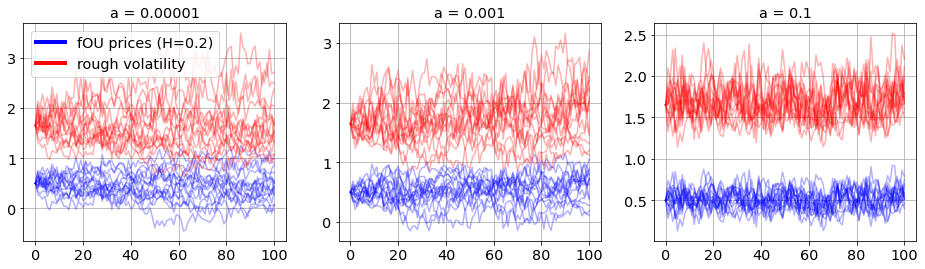

In [4]:
custom_lines = [Line2D([0], [0], color='blue', lw=4), Line2D([0], [0], color='red', lw=4)]

fig, ax = plt.subplots(1, 3)

k=0
for df_p, df_v, a, axx in zip(list_df_prices, list_df_vols, [a1,a2,a3], ax.flatten()):
    if a<1e-4:
        title = 'a = {:.5f}'.format(a)
    else:
        title = 'a = {}'.format(a)
    df_p.plot(grid=True, title=title, legend=False, c='blue', alpha=0.3, ax=axx)
    df_v.plot(grid=True, legend=False, c='red', alpha=0.3, ax=axx)
    if k==0:
        axx.legend(custom_lines, ['fOU prices (H=0.2)', 'rough volatility'])
    k+=1

#plt.savefig('../pictures/fOU_rough_vol.png', bbox_inches='tight')
plt.show()

# Set up experiment parameters

In [22]:
N = 100 # change to 20, 50, 100 to reproduce the experiments

In [23]:
M = 50
length = 200

max_T = 1e0
min_T = 1e-6
np.random.seed(0)
y = np.array((max_T-min_T)*np.random.rand(M)+min_T)

In [24]:
X = []
    
for a in tqdm(y):
    intermediate = []
    for n in range(N):
        path = np.exp(utils_roughvol.fOU_generator(a, length=length)).reshape(-1,1)
        intermediate.append(path)
    X.append(intermediate)

100%|██████████| 50/50 [00:19<00:00,  2.50it/s]


# SES

In [25]:
SES_mse, SES_std_mse, results_SES = SES.model(X, y, depths1=[2,3,4], depth2=2, ll=[0], at=True, NUM_TRIALS=5, cv=3)

 20%|██        | 1/5 [00:09<00:38,  9.70s/it]

best truncation level (cv on train set):  3


 40%|████      | 2/5 [00:19<00:29,  9.73s/it]

best truncation level (cv on train set):  3


 60%|██████    | 3/5 [00:29<00:19,  9.81s/it]

best truncation level (cv on train set):  2


 80%|████████  | 4/5 [00:39<00:09,  9.83s/it]

best truncation level (cv on train set):  2


100%|██████████| 5/5 [00:49<00:00,  9.85s/it]

best truncation level (cv on train set):  2


# SES-MC

In [26]:
SES_MC_mse, SES_MC_std_mse, results_SES_MC = SES.model(X, y, depths1=[2,3,4], depth2=2, ll=[0], at=True, NUM_TRIALS=5, cv=3, martingale_indices=[0])

 20%|██        | 1/5 [00:14<00:59, 14.97s/it]

best truncation level (cv on train set):  3


 40%|████      | 2/5 [00:29<00:44, 14.99s/it]

best truncation level (cv on train set):  3


 60%|██████    | 3/5 [00:44<00:29, 14.87s/it]

best truncation level (cv on train set):  2


 80%|████████  | 4/5 [00:58<00:14, 14.72s/it]

best truncation level (cv on train set):  2


100%|██████████| 5/5 [01:13<00:00, 14.65s/it]

best truncation level (cv on train set):  3


# Results

In [27]:
print(f'SES: {SES_mse} ({SES_std_mse})')
print(f'SES-MC: {SES_MC_mse} ({SES_MC_std_mse})')

SES: 0.0001968579968887206 (8.20712508307526e-05)
SES-MC: 0.00019126854330702654 (5.000761920139384e-05)


**Save results**

In [28]:
import pickle
results = {'SES': results_SES, 'SES-MC': results_SES_MC} 
pickle.dump(results, open(f'results/finance/roughvol_{N}.pkl','wb'))

**Compare results**

In [63]:
import pickle

results_20 = pickle.load(open(f'results/finance/roughvol_20.pkl', 'rb'))
results_50 = pickle.load(open(f'results/finance/roughvol_50.pkl', 'rb'))
results_100 = pickle.load(open(f'results/finance/roughvol_100.pkl', 'rb'))

In [70]:
import scipy.stats
import numpy as np

def t_test_mses(results1, results2):
    assert len(results1) == len(results2)
    n = len(results1)
    mses1 = np.zeros(n)
    mses2 = np.zeros(n)
 
    for i in range(n):
        mses1[i]=np.mean((results1[i]['pred'] - results1[i]['true'])**2)
        mses2[i]=np.mean((results2[i]['pred'] - results2[i]['true'])**2)

    t_stat, p_value = scipy.stats.ttest_rel(mses1, mses2)

    return np.mean(mses1), np.std(mses1), np.mean(mses2), np.std(mses2), t_stat, p_value

In [93]:
t_test_results = {}
for N, results in zip([20, 50, 100], [results_20, results_50, results_100]):
    mse_SES, std_mse_SES, mse_SES_MC, std_mse_SES_MC, t_stat, p_value = t_test_mses(results['SES'], results['SES-MC'])
    t_test_results[f"N={N}"] = [f"{mse_SES*1e3:.2f} ({std_mse_SES*1e3:.2f})", f"{mse_SES_MC*1e3:.2f} ({std_mse_SES_MC*1e3:.2f})", f"{t_stat:.2f}", f"{p_value:.2f}"]

In [94]:
df = pd.DataFrame(t_test_results, index=['SES', 'SES-MC', 't-stat', 'p-value'])
df.columns = pd.MultiIndex.from_product([['Predictive MSE [1e-3]'], df.columns])
df

Predictive MSE [1e-3]                          
                         N=20         N=50        N=100
SES               1.49 (0.39)  0.33 (0.13)  0.20 (0.08)
SES-MC            1.26 (0.48)  0.31 (0.09)  0.19 (0.05)
t-stat                   0.87         0.63         0.29
p-value                  0.43         0.56         0.79

In [95]:
print(df.to_latex())

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{Predictive MSE [1e-3]} \\
{} &                  N=20 &         N=50 &        N=100 \\
\midrule
SES     &           1.49 (0.39) &  0.33 (0.13) &  0.20 (0.08) \\
SES-MC  &           1.26 (0.48) &  0.31 (0.09) &  0.19 (0.05) \\
t-stat  &                  0.87 &         0.63 &         0.29 \\
p-value &                  0.43 &         0.56 &         0.79 \\
\bottomrule
\end{tabular}

